# Defining Accelerator

In [0]:
'''
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
'''

"\nimport torch\ndevice = torch.device('cuda' if torch.cuda.is_available() else 'cpu')\nprint(device)\n"

In [0]:
import os
assert os.environ['COLAB_TPU_ADDR']

In [0]:
VERSION = "20200325"  #@param ["1.5" , "20200325", "nightly"]
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version $VERSION

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4264  100  4264    0     0  65600      0 --:--:-- --:--:-- --:--:-- 64606
Updating TPU and VM. This may take around 2 minutes.
Updating TPU runtime to pytorch-dev20200325 ...
Uninstalling torch-1.5.0a0+d6149a7:
  Successfully uninstalled torch-1.5.0a0+d6149a7
Uninstalling torchvision-0.6.0a0+3c254fb:
  Successfully uninstalled torchvision-0.6.0a0+3c254fb
Copying gs://tpu-pytorch/wheels/torch-nightly+20200325-cp36-cp36m-linux_x86_64.whl...
\ [1 files][ 83.4 MiB/ 83.4 MiB]                                                
Operation completed over 1 objects/83.4 MiB.                                     
Copying gs://tpu-pytorch/wheels/torch_xla-nightly+20200325-cp36-cp36m-linux_x86_64.whl...
- [1 files][114.5 MiB/114.5 MiB]                                                
Operation completed over 1 objects/114.5 MiB.               

In [0]:
# imports the torch_xla package
import torch
import torch_xla
import torch_xla.core.xla_model as xm

dev = xm.xla_device()

# Importing Requisite Modules

In [0]:
import random
import sys
import zipfile
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from skimage.io import imread
from skimage.transform import resize

# Extracting Relevant Files

In [0]:
with zipfile.ZipFile(os.path.join('/content/drive/My Drive/monet2photo.zip')) as z:
  z.extractall('/content/drive/My Drive/monet2photo')

In [0]:
TRAIN_PATH_A = '/content/drive/My Drive/monet2photo/monet2photo/trainA/'
TRAIN_PATH_B = '/content/drive/My Drive/monet2photo/monet2photo/trainB/'

TEST_PATH_A = '/content/drive/My Drive/monet2photo/monet2photo/testA/'
TEST_PATH_B = '/content/drive/My Drive/monet2photo/monet2photo/testB/'

In [0]:
train_files_A = next(os.walk(TRAIN_PATH_A))[2]
train_files_B = next(os.walk(TRAIN_PATH_B))[2]

test_files_A = next(os.walk(TEST_PATH_A))[2]
test_files_B = next(os.walk(TEST_PATH_B))[2]

In [0]:
#Checking training data shape
demo = imread(TRAIN_PATH_A + train_files_A[0])
print(demo.shape)

(256, 256, 3)


# Loading Training & Test Data

In [0]:
X_train_A = np.zeros((len(train_files_A), 256, 256, 3), dtype = np.uint8)
X_train_B = np.zeros((len(train_files_B), 256, 256, 3), dtype = np.uint8)

X_test_A = np.zeros((len(test_files_A), 256, 256, 3), dtype = np.uint8)
X_test_B = np.zeros((len(test_files_B), 256, 256, 3), dtype = np.uint8)

print('Getting training images from set A...')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(train_files_A), total = len(train_files_A)):
  img_path = TRAIN_PATH_A + id_
  img = imread(img_path)[:, :, :3]
  X_train_A[n] = img

print('Getting training images from set B...')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(train_files_B), total = len(train_files_B)):
  img_path = TRAIN_PATH_B + id_
  img = imread(img_path)[:, :, :3]
  X_train_B[n] = img

print('Getting testing images from set A...')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(test_files_A), total = len(test_files_A)):
  img_path = TEST_PATH_A + id_
  img = imread(img_path)[:, :, :3]
  X_test_A[n] = img

print('Getting testing images from set B...')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(test_files_B), total = len(test_files_B)):
  img_path = TEST_PATH_B + id_
  img = imread(img_path)[:, :, :3]
  X_test_B[n] = img

print('Done!')

Getting training images from set A...


100%|██████████| 1072/1072 [00:04<00:00, 257.41it/s]

Getting training images from set B...



100%|██████████| 6287/6287 [00:28<00:00, 219.73it/s]

Getting testing images from set A...



100%|██████████| 121/121 [00:00<00:00, 246.62it/s]

Getting testing images from set B...



100%|██████████| 751/751 [00:02<00:00, 255.45it/s]

Done!


# Data Visualization

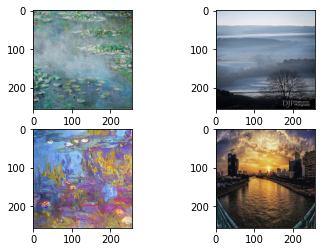

In [0]:
fig, axis = plt.subplots(2, 2)
axis[0][0].imshow(X_train_A[0].astype(np.uint8))
axis[0][1].imshow(X_train_B[0].astype(np.uint8))
axis[1][0].imshow(X_test_A[0].astype(np.uint8))
axis[1][1].imshow(X_test_B[0].astype(np.uint8))

In [0]:
#Sanity check of shapes
print(X_train_A.shape)
print(X_train_B.shape)
print(X_test_A.shape)
print(X_test_B.shape)

(1072, 256, 256, 3)
(6287, 256, 256, 3)
(121, 256, 256, 3)
(751, 256, 256, 3)


# Random Jitter Using Data Augmentation

In [0]:
class pix2pix(Dataset):
    def __init__(self, input_imgs_np):
        self.input_imgs_np = input_imgs_np
        
    def transform(self, input_img_np):
        input_img = TF.to_pil_image(input_img_np)
        input_img = TF.resize(input_img, (286, 286))
        
        random_crop = transforms.RandomCrop((256, 256))
        input_img = random_crop(input_img)
        
        if random.random() > 0.5:
            input_img = TF.hflip(input_img)
            
        input_tensor = TF.to_tensor(input_img)
        return input_tensor
    
    def __len__(self):
        return len(self.input_imgs_np)
    
    def __getitem__(self, idx):
        input_img_np = self.input_imgs_np[idx]
        input_tensor = self.transform(input_img_np)
        return input_tensor   

In [0]:
train_dataset_A = pix2pix(X_train_A)
train_loader_A = DataLoader(train_dataset_A, batch_size = 1, shuffle = True)

train_dataset_B = pix2pix(X_train_B)
train_loader_B = DataLoader(train_dataset_B, batch_size = 1, shuffle = True)

# Passing Data to List

In [0]:
train_A = []
train_B = []

for img in train_loader_A:
  train_A.append(img)

for img in train_loader_B:
  train_B.append(img)

In [0]:
print(len(train_A))
print(train_A[0].shape)

1072
torch.Size([1, 3, 256, 256])


# Data Visualization Post Augmentation

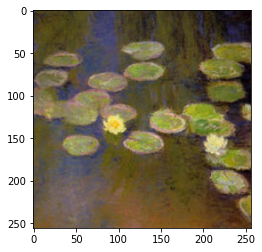

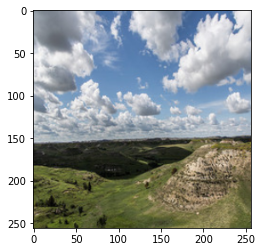

In [0]:
x_np = np.array(TF.to_pil_image(train_A[0][0]))
plt.imshow(x_np)
plt.show()

x_np = np.array(TF.to_pil_image(train_B[0][0]))
plt.imshow(x_np)
plt.show()

# Random Weight Initialization from Normal Distribution

In [0]:
def weight_init(instance):
    classname = instance.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(instance.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(instance.weight.data, 0.0, 0.02)
        nn.init.constant_(instance.bias.data, 0.0)

# Convolutional & Fractional Convolution Blocks With ReLU Activation

In [0]:
def conv_block(in_channels, out_channels, *args, **kwargs):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, *args, **kwargs),
      nn.InstanceNorm2d(out_channels),
      nn.ReLU()
  )

def deconv_block(in_channels, out_channels, *args, **kwargs):
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, *args, **kwargs),
      nn.InstanceNorm2d(out_channels),
      nn.ReLU()
  )            

# Resnet Module

In [0]:
class resnet(nn.Module):
  def __init__(self, in_channels, n_filters):
    super().__init__()
    self.conv_block_1 = conv_block(in_channels, n_filters, kernel_size = (3, 3), padding = 1, padding_mode = 'reflect')
    self.conv_2 = nn.Conv2d(n_filters, n_filters, kernel_size = (3, 3), padding = 1, padding_mode = 'reflect')
    self.conv_2_in = nn.InstanceNorm2d(n_filters)

  def forward(self, x):
    c = self.conv_block_1(x)
    c = self.conv_2(c)
    c = self.conv_2_in(c)
    out = torch.cat((c, x), axis = 1)
    return out

# Generator Model

In [0]:
class generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_blocks = nn.Sequential(
        conv_block(3, 64, kernel_size = (7, 7), padding = 3, padding_mode = 'reflect'),
        conv_block(64, 128, kernel_size = (3, 3), stride = 2, padding = 1, padding_mode = 'reflect'),
        conv_block(128, 256, kernel_size = (3, 3), stride = 2, padding = 1, padding_mode = 'reflect'),
    )

    self.resnet_blocks = nn.Sequential(
        resnet(256, 256),
        resnet(512, 256),
        resnet(768, 256),
        resnet(1024, 256),
        resnet(1280, 256),
        resnet(1536, 256),
        resnet(1792, 256),
        resnet(2048, 256),
        resnet(2304, 256)
      )
    
    self.deconv_blocks = nn.Sequential(
        deconv_block(2560, 128, kernel_size = (3, 3), stride = 2, padding = 1, output_padding = 1),
        deconv_block(128, 64, kernel_size = (3, 3), stride = 2, padding = 1, output_padding = 1),
        nn.Conv2d(64, 3, kernel_size = (7, 7), padding = 3, padding_mode = 'reflect'),
        nn.InstanceNorm2d(3),
        nn.Tanh()
    )

  def forward(self, x):
    x = self.conv_blocks(x)

    x = self.resnet_blocks(x)

    out = self.deconv_blocks(x)

    return out

In [0]:
#Creating generator objects
gen_AtoB = generator()
gen_AtoB = gen_AtoB.float()
gen_AtoB = gen_AtoB.to(dev)
gen_AtoB.apply(weight_init)

gen_BtoA = generator()
gen_BtoA = gen_BtoA.float()
gen_BtoA = gen_BtoA.to(dev)
gen_BtoA.apply(weight_init)

#Printing one instance
print(gen_AtoB)

#Total trainable params
total_params = sum(p.numel() for p in gen_AtoB.parameters() if p.requires_grad)
print(total_params)

generator(
  (conv_blocks): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), padding_mode=reflect)
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU()
    )
  )
  (resnet_blocks): Sequential(
    (0): resnet(
      (conv_block_1): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
        (1): InstanceNorm2d(256, eps=1e-05, mom

# Convolutional Block With Leaky ReLU Activation

In [0]:
def conv_block_leaky(in_channels, out_channels, *args, **kwargs):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, *args, **kwargs),
      nn.InstanceNorm2d(out_channels),
      nn.LeakyReLU(0.2)
  )

# Discriminator Model

In [0]:
class discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size = (4, 4), stride = 2, padding = 1),
        nn.LeakyReLU(negative_slope = 0.2)
    )

    self.conv_blocks = nn.Sequential(
        conv_block_leaky(64, 128, kernel_size = (4, 4), stride = 2, padding = 1),
        conv_block_leaky(128, 256, kernel_size = (4, 4), stride = 2, padding = 1),
        nn.ZeroPad2d(1),
        conv_block_leaky(256, 512, kernel_size = (4, 4), stride = 1)
    )

    self.conv_block_last = nn.Sequential(
        nn.ZeroPad2d(1),
        nn.Conv2d(512, 1, kernel_size = (4, 4), stride = 1),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    
    x = self.conv_blocks(x)

    out = self.conv_block_last(x) 

    return out

In [0]:
#Creating discriminator objects
disc_A = discriminator()
disc_A = disc_A.float()
disc_A = disc_A.to(dev)
disc_A.apply(weight_init)

disc_B = discriminator()
disc_B = disc_B.float()
disc_B = disc_B.to(dev)
disc_B.apply(weight_init)

#Printing one instance
print(disc_A)

#Total trainable params
total_params = sum(p.numel() for p in disc_A.parameters() if p.requires_grad)
print(total_params)

discriminator(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
  )
  (conv_blocks): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (2): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1))
      (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
  )
  (conv_block_last): Sequential(
    (

# Adversarial Losses

In [0]:
def gen_loss_gan(gen_disc_out):
  target = torch.ones((gen_disc_out.shape[0], 1, 30, 30)).to(dev)
  loss = nn.MSELoss()(gen_disc_out.float(), target.float())
  return loss

def disc_loss_gan(real_out, fake_out):
  real_target = torch.ones((real_out.shape[0], 1, 30, 30)).to(dev)
  fake_target = torch.zeros((fake_out.shape[0], 1, 30, 30)).to(dev)
  real_loss = nn.MSELoss()(real_out.float(), real_target.float())
  fake_loss = nn.MSELoss()(fake_out.float(), fake_target.float())
  total_loss = (real_loss + fake_loss)/2.0
  return total_loss

# Cycle Consistency Loss

In [0]:
def cycle_loss(orig, regen):
  loss = nn.L1Loss()(regen.float(), orig.float())
  return loss

# Train Data Generators

In [0]:
def generate_real_sample(dataset):
  idx = random.randint(0, len(dataset) - 1)
  return dataset[idx]

def generate_fake_sample(gen_obj, img_obj):
  img_obj = img_obj.to(dev)
  fake_img = gen_obj(img_obj.float())
  return fake_img

In [0]:
out_sample = generate_fake_sample(gen_AtoB, train_A[0])
print(isinstance(train_A[0], torch.Tensor))
print(isinstance(out_sample, torch.Tensor))

True
True


# Image Pool 

In [0]:
def update_pool(pool, image):
  
  if len(pool) < 50:
    pool.append(image)
    return image

  else:
    if random.random() > 0.5:
      p = random.randint(0, len(pool) - 1)
      tmp = pool[p]
      pool[p] = image
      return tmp

    else:
      return image

# Defining Optimizers

In [0]:
gen_opt_AtoB = optim.Adam(gen_AtoB.parameters(), lr = 0.0002, betas = (0.5, 0.999))
gen_opt_BtoA = optim.Adam(gen_BtoA.parameters(), lr = 0.0002, betas = (0.5, 0.999))

disc_opt_A = optim.Adam(disc_A.parameters(), lr = 0.0002, betas = (0.5, 0.999))
disc_opt_B = optim.Adam(disc_B.parameters(), lr = 0.0002, betas = (0.5, 0.999))

# Training

In [0]:
def train(gen_AtoB, gen_BtoA, disc_A, disc_B, gen_opt_AtoB, gen_opt_BtoA, disc_opt_A, disc_opt_B, train_A, train_B, num_epochs, Lambda):

  gen_AtoB_losses = []
  gen_BtoA_losses = []
  disc_A_losses = []
  disc_B_losses = []

  gen_AtoB.train()
  gen_BtoA.train()
  disc_A.train()
  disc_B.train()

  sample_img_A = train_A[0].to(dev)
  sample_img_B = train_B[0].to(dev)

  for epoch in range(num_epochs + 1):
    
    gen_AtoB_total = 0
    gen_BtoA_total = 0
    disc_A_total = 0
    disc_B_total = 0

    pool_A = []
    pool_B = []
    
    for _ in range(len(train_A)):

      real_A = generate_real_sample(train_A)
      real_A = real_A.to(dev)
      real_B = generate_real_sample(train_B)
      real_B = real_B.to(dev)

      fake_A = generate_fake_sample(gen_BtoA, real_B)
      fake_B = generate_fake_sample(gen_AtoB, real_A)
      
      #Discriminator A training
      disc_opt_A.zero_grad()
      
      real_disc_A_out = disc_A(real_A.float())
      fake_disc_A_in = fake_A.detach()
      fake_disc_A_in = update_pool(pool_A, fake_disc_A_in)
      
      fake_disc_A_out = disc_A(fake_disc_A_in.float())
      disc_loss_A = disc_loss_gan(real_disc_A_out, fake_disc_A_out)
      disc_A_total += disc_loss_A 

      disc_loss_A.backward()
      disc_opt_A.step()

      #Discriminator B training
      disc_opt_B.zero_grad()
      
      real_disc_B_out = disc_B(real_B.float())
      fake_disc_B_in = fake_B.detach()
      fake_disc_B_in = update_pool(pool_B, fake_disc_B_in)
      
      fake_disc_B_out = disc_A(fake_disc_B_in.float())
      disc_loss_B = disc_loss_gan(real_disc_B_out, fake_disc_B_out)
      disc_B_total += disc_loss_B 

      disc_loss_B.backward()
      disc_opt_B.step()

      #Generator AtoB training
      gen_opt_AtoB.zero_grad()

      real_fake_out_B = disc_B(fake_B.float())                 #Calculating adversarial loss
      gen_AtoB_gan_loss = gen_loss_gan(real_fake_out_B)

      fake_A_detach = fake_A.detach()                          #Calculating cyclic consistency loss
      recon_B = generate_fake_sample(gen_AtoB, fake_A_detach)
      gen_AtoB_cyc_loss = cycle_loss(real_B, recon_B)

      gen_AtoB_loss = gen_AtoB_gan_loss + Lambda*gen_AtoB_cyc_loss
      gen_AtoB_total += gen_AtoB_loss

      gen_AtoB_loss.backward()
      gen_opt_AtoB.step()

      #Generator BtoA training
      gen_opt_BtoA.zero_grad()

      real_fake_out_A = disc_A(fake_A.float())                  #Calculating adversarial loss
      gen_BtoA_gan_loss = gen_loss_gan(real_fake_out_A)

      fake_B_detach = fake_B.detach()                           #Calculating cyclic consistency loss
      recon_A = generate_fake_sample(gen_BtoA, fake_B_detach)
      gen_BtoA_cyc_loss = cycle_loss(real_A, recon_A)

      gen_BtoA_loss = gen_BtoA_gan_loss + Lambda*gen_BtoA_cyc_loss
      gen_BtoA_total += gen_BtoA_loss

      gen_BtoA_loss.backward()
      gen_opt_BtoA.step()

    gen_AtoB_losses.append(gen_AtoB_total)
    gen_BtoA_losses.append(gen_BtoA_total)
    disc_A_losses.append(disc_A_total)
    disc_B_losses.append(disc_B_total)

    print('Epoch ', epoch, ' - ', 'Gen_A2B_Loss = ', gen_AtoB_total/len(train_A), ' Gen_B2A_Loss = ', gen_BtoA_total/len(train_A))
    sys.stdout.flush()
    print('Disc_A_Loss = ', disc_A_total/len(train_A), ' Disc_B_Loss = ', disc_B_total/len(train_A))
    sys.stdout.flush()

    #Printing a set of images to monitor progress every 5 epochs
    if epoch % 5 == 0:
      gen_AtoB.eval()
      sample_out_B = gen_AtoB(sample_img_A.float())
      gen_AtoB.train()

      gen_BtoA.eval()
      sample_out_A = gen_BtoA(sample_img_B.float())
      gen_BtoA.train()

      sample_img_A = sample_img_A.cpu()
      sample_img_B = sample_img_B.cpu()
      sample_out_A = sample_out_A.cpu()
      sample_out_B = sample_out_B.cpu()

      sample_img_A_np = np.array(TF.to_pil_image(sample_img_A[0]))
      sample_img_B_np = np.array(TF.to_pil_image(sample_img_B[0]))
      sample_out_A_np = np.array(TF.to_pil_image(sample_out_A[0]))
      sample_out_B_np = np.array(TF.to_pil_image(sample_out_B[0]))

      fig, axis = plt.subplots(2, 2)
      axis[0][0].imshow(sample_img_A_np.astype(np.uint8))
      axis[0][0].axis('off')
      axis[1][0].imshow(sample_out_B_np.astype(np.uint8))
      axis[1][0].axis('off')
      axis[0][1].imshow(sample_img_B_np.astype(np.uint8))
      axis[0][1].axis('off')
      axis[1][1].imshow(sample_out_A_np.astype(np.uint8))
      axis[1][1].axis('off')
      plt.show()

  return gen_AtoB_losses, gen_BtoA_losses, disc_A_losses, disc_B_losses

In [0]:
gen_AtoB_losses, gen_BtoA_losses, disc_A_losses, disc_B_losses = train(gen_AtoB, gen_BtoA, disc_A, disc_B, gen_opt_AtoB, gen_opt_BtoA, disc_opt_A, disc_opt_B, train_A, train_B, 100, 10)